# Neural Networks
## Homework 1: Implementing advanced activation functions

**Name**: Gabriele G. Di Marzo

**Matricola**: 2012633

Upload the completed notebook **before 30/11/2022 at 23:59** on the Google Classrom page.

In [1]:
import torch
import matplotlib.pyplot as plt


### Objective

The purpose of this homework is to implement a new layer inside PyTorch, by properly extending the `nn.Module` object. **Before proceeding**, carefully read the following documentation:

+ [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module)
+ [PyTorch: Custom Module](https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html)

You can also (optionally) learn more about activation functions by reading the survey in [1].

### Introduction: families of activation functions

In the course up to now, we have seen the application of the sigmoid, the softmax, and the ReLU. However, many additional activation functions exist [1], with varying strengths and drawbacks.

Several of them are designed as variants of the ReLU. The **S-Shaped ReLU** (SReLU) [2] is defined as:

$$
\phi(s) = \begin{cases} t^r + a^r(s - t^r) & \text{ if } s > t^r \\ s & \text{ if } t^r > s > t^l \\ t^l + a^l(s - t^l) & \text{ if } s < t^l \end{cases} \,.
$$

The four parameters $t^r, a^r, t^l, a^l$ are trained via back-propagation, and they are **different for each unit in the layer**. 


### Exercise 1: implementing an activation function (1 point)

Let us start with the simpler **[exponential linear squashing](https://paperswithcode.com/method/elish)** (ELiSH) activation function:

$$
\phi(x) = \begin{cases} \sigma(x)x & \text{ if } x \ge 0 \\ \frac{\exp(x) - 1}{1 + \exp(-x)} & \text{ otherwise} \end{cases}
$$

**Exercise 1**: complete the following stub.

In [2]:
def elish(x):
  # x is a generic torch.Tensor, and this function must compute the ELiSH activation function.
    return torch.where(x>=0, torch.sigmoid(x)*x, torch.sigmoid(x)*(torch.exp(x) - 1 ))


**Hints for a correct implementation**:

1. There are several ways of implementing an if/else operation like the one above in PyTorch. In general, the simplest implementation of "*if a then b, else c*" is `torch.where(a, b, c)` (see the documentation for [torch.where](https://pytorch.org/docs/stable/generated/torch.where.html)). Any working variant is accepted here.

Here is a simple sanity check for the correct implementation:

In [3]:
elish(torch.FloatTensor([[0.2, -0.4]])) # Should be approximately [[0.11, -0.13]]

tensor([[ 0.1100, -0.1323]])

### Exercise 2: some visualization experiments (1 point)

**Exercise 2.1**: plot the ELiSH function in [-5, +5].

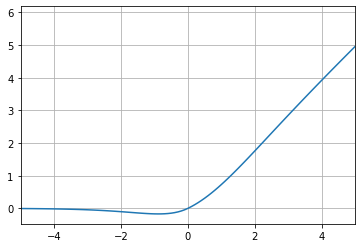

In [4]:
vals = torch.arange(-5., 6., 0.1)
x = torch.arange(-5., 6., 0.1, requires_grad=True )
plt.plot(vals, elish(vals))
plt.xlim([-5, 5])
plt.grid(True)
plt.show()

**Exercise 2.2**: using the utilities from `torch.autograd` ([torch.autograd](https://pytorch.org/docs/stable/autograd.html)), **compute and plot** the derivative of ELiSH using automatic differentiation.

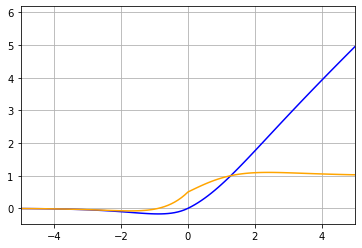

In [5]:
# TODO: plot the gradient of the ELiSH function
x = torch.arange(-5, 6, 0.1, requires_grad=True )
plt.plot(vals, elish(vals), 'blue')
plt.xlim([-5, 5])
plt.grid(True)

y = torch.sum(elish(x))
y.backward()

plt.grid(True)
plt.plot( vals, x.grad.detach().numpy(), 'orange')
plt.xlim([-5, 5])
plt.show()


**Exercise 2.3 (sanity check)**: build a model using the previously defined activation function, and test it on a random mini-batch of data:

In [6]:
# TODO: complete the definition of the model
class RandomModel(torch.nn.Module): 
  def __init__(self, funct): 
    super().__init__()
    self.l1 = torch.nn.Linear(10, 10)
    self.l2 = torch.nn.Linear(10, 2)
    self.funct = funct
  
  def forward(self, x): 
    x = self.l1(x)
    x = self.funct(x)
    x = self.l2(x)
    return x
    

model = RandomModel(elish)

print(model(torch.randn((5, 10))))

tensor([[-0.0776,  0.2435],
        [-0.4077,  0.1592],
        [-0.2564, -0.0069],
        [-0.0840, -0.2627],
        [-0.1061,  0.0534]], grad_fn=<AddmmBackward0>)


## Exercise 3: implementing a trainable activation function (2 points)

**Exercise 3:** define a `torch.nn.Module` implementing the SReLU.

**Hints for a correct implementation**:
* The layer should **only** implement the activation function. Ideally, it will always be used in combination with a fully-connected layer with no activation function.
* Think carefully about how you want to initialize the parameters.

In [ ]:
from torch.nn.parameter import Parameter

class SReLU(torch.nn.Module):
  def __init__(self, units):
    super().__init__()
    self.units = units


    self.alpha1 = Parameter(torch.randn((self.units), requires_grad=True))
    self.beta1 = Parameter(torch.randn((self.units), requires_grad=True))

    self.alpha2 = Parameter(torch.randn((self.units), requires_grad=True))
    self.beta2 = Parameter(torch.randn((self.units), requires_grad=True))

  
  def forward(self, x):
    return torch.where(x>self.beta1, self.beta1 + self.alpha1*(x - self.beta1),
                torch.where(
                    self.beta2>x, x,  self.beta2 + self.alpha2*(x-self.beta2))
                 )
    
    

As a sanity check, initialize a SReLU layer and count the number of parameters:

In [ ]:
# Initialize the layer
layer = SReLU(2)
# Count the parameters
numb_params = sum([p.numel() for p in layer.parameters() if p.requires_grad])
print( numb_params ) # Should print 8!

8


## Exercise 4: training a model with trainable activation functions (1 point)

We will use the following dataset from TensorFlow Datasets:
https://www.tensorflow.org/datasets/catalog/german_credit_numeric

In [ ]:
import tensorflow_datasets as tfds
import torch.optim as optim 
from collections import OrderedDict
from torch.utils.data import DataLoader
from sklearn import preprocessing
from numpy import mean

In [ ]:
class dataset(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X                           
    self.Y = Y       

  def __len__(self):
    return len(self.X)                  

  def __getitem__(self, idx):
    return [self.X[idx], self.Y[idx]]

train_data = tfds.load('german_credit_numeric', split='train[:75%]', as_supervised=True)
Xtrain, ytrain = train_data.batch(5000).get_single_element()


In [ ]:
train_data = tfds.load('german_credit_numeric', split='train[:75%]', as_supervised=True)
Xtrain, ytrain = train_data.batch(5000).get_single_element()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/german_credit_numeric/1.0.0.incompleteAARTBJ/german_credit_numeric-train.tfrec…

Dataset german_credit_numeric downloaded and prepared to ~/tensorflow_datasets/german_credit_numeric/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data = tfds.load('german_credit_numeric', split='train[:75%]', as_supervised=True)
test_data = tfds.load('german_credit_numeric', split='train[75%:]', as_supervised=True)

Xtrain, ytrain = train_data.batch(5000).get_single_element()
Xtrain, ytrain = preprocessing.normalize(Xtrain.numpy()), ytrain.numpy()
Xtrain, ytrain = torch.Tensor(Xtrain), torch.Tensor(ytrain)

Xtest, ytest = test_data.batch(5000).get_single_element()
Xtest, ytest = preprocessing.normalize(Xtest.numpy()), ytest.numpy()
Xtest, ytest = torch.Tensor(Xtest), torch.Tensor(ytest)

In [ ]:
train_loader = DataLoader(dataset(Xtrain, ytrain), batch_size=128, shuffle=True)
test_loader = DataLoader(dataset(Xtest, ytest), batch_size=128, shuffle=False)

**Exercise 4**: write a `nn.Module` using the previous `SReLU`, and train it on the german_credit_numeric dataset.

In [ ]:
model = torch.nn.Sequential(OrderedDict([
          
          ('Linear1', torch.nn.Linear(24,10)),
          ('SReLU1', SReLU(10)),
          
          ('Lin2', torch.nn.Linear(10, 10)),
          ('SReLU2', SReLU(10)),
          ('drop2', torch.nn.Dropout(p=0.5)),
          
          ('Linear3', torch.nn.Linear(10, 5)), 
          #('relu3', torch.nn.ReLU()),
          ('SReLU3', SReLU(5)),

          ('Linear4', torch.nn.Linear(5,1)),
          ('Sigmoid', torch.nn.Sigmoid())
        ]))

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
losses = []
epochs = 300
model.train()
for epoch in range(epochs): 
  epoch_loss = []
  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    y_pred = model(inputs)
    loss = criterion(y_pred, labels.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.detach().item())

  losses.append(mean(epoch_loss))

model.eval()

Sequential(
  (Linear1): Linear(in_features=24, out_features=10, bias=True)
  (SReLU1): SReLU()
  (Lin2): Linear(in_features=10, out_features=10, bias=True)
  (SReLU2): SReLU()
  (drop2): Dropout(p=0.5, inplace=False)
  (Linear3): Linear(in_features=10, out_features=5, bias=True)
  (SReLU3): SReLU()
  (Linear4): Linear(in_features=5, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

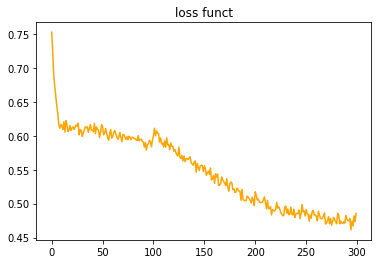

ultimo valore loss : 0.4855262537797292


In [ ]:
plt.plot(range(epochs), losses, 'orange')
plt.title('loss funct')
plt.show()
print(f'ultimo valore loss : {losses[-1]}')


In [ ]:
acc_test = 0
acc_train = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
      inputs, labels = data
      outputs = model(inputs)
      outputs = [1 if outputs[i]>=0.5 else 0 for i in range(len(outputs))]
      acc_test += sum([1 if outputs[i]==labels[i] else 0 for i in range(len(labels))])
    
    for i, data in enumerate(train_loader):
      inputs, labels = data
      outputs = model(inputs)
      outputs = [1 if outputs[i]>=0.5 else 0 for i in range(len(outputs))]
      acc_train += sum([1 if outputs[i]==labels[i] else 0 for i in range(len(labels))])

print(f'test accuracy   : {acc_test*100/len(test_data)}')
print(f'train accuracy  : {acc_train*100/len(train_data)}')


test accuracy   : 73.2
train accuracy  : 77.2


**Optionally**, you can plot the distribution (histogram) of the parameters after training.

In [ ]:
# TODO: plot the histogram
plt.hist( ... )

## Final checklist
1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send us notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 30/11/2021 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. [A survey on modern trainable activation functions](https://arxiv.org/abs/2005.00817).

[2] Jin, X., Xu, C., Feng, J., Wei, Y., Xiong, J. and Yan, S., 2016. [Deep learning with s-shaped rectified linear activation units](https://arxiv.org/abs/1512.07030). In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 30, No. 1).